# Gradient verification for the 1D pure diffusion case

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

GOAL: check that the gradient is zero (porosity does not matter in a pure diffusion case).

In [1]:
import copy
import logging
import os
from pathlib import Path
from typing import Generator, Iterable

import gstools as gs
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import scipy as sp
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from matplotlib.collections import PolyCollection
from pyrtid.utils import (
    NDArrayFloat,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions


In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path: str = os.path.dirname(os.path.realpath("__file__"))
fig_save_path: Path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
nx = 20  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 10.0  # voxel dimension along the x axis
dy = 10.0  # voxel dimension along the y axis
duration_in_d = 50  # number of time steps
duration_in_s = duration_in_d * 3600 * 24
dt_init = 4000.0  # timestep in seconds
dt_min = 2000.0
dt_max = 5000.0
c0 = 0  # general initial cocentration
D0 = 1e-4  # general initial diffusion coefficient
k0 = 1e-8  # permeability in m/s
w0 = 0.23  # general porosity
crank_nicolson_diffusion = 1.0

- x_coordinates array for the plots

In [7]:
x_positions_in_meters = (np.arange(nx) + 0.5) * dx

- Consider three observation locations

In [8]:
observation_locations = [6, 10, 15]

- Create an initial "bumped" reference distribution for the diffusion, and a flat one for the initial estimation.

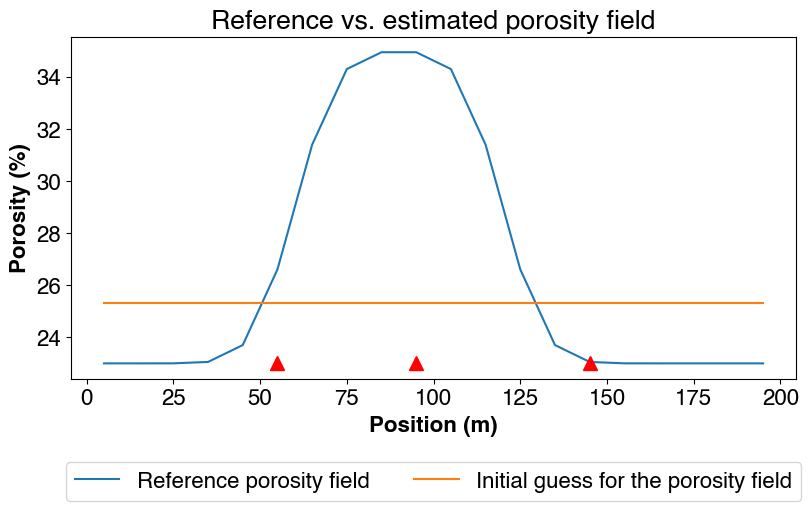

In [9]:
porosity_reference: NDArrayFloat = np.ones(nx) * w0
porosity_reference[6:12] = 0.35
porosity_reference = sp.ndimage.gaussian_filter(porosity_reference, sigma=1)

# Estimated diffusion
porosity_estimated: NDArrayFloat = np.ones(nx) * w0 * 1.1
# porosity_reference: NDArrayFloat = np.ones(nx) * w0 * 2.0

plotter = ngp.NestedGridPlotter(fig_params={"figsize": (8, 5)})
ax = plotter.ax_dict["ax1-1"]
ax.plot(
    x_positions_in_meters, porosity_reference * 100, label="Reference porosity field"
)
ax.plot(
    x_positions_in_meters,
    porosity_estimated * 100,
    label="Initial guess for the porosity field",
)
ax.set_xlabel("Position (m)", weight="bold")
ax.set_ylabel("Porosity (%)", weight="bold")
# ax.set_yscale("log")
ax.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
ax.set_title("Reference vs. estimated porosity field")
plotter.fig.set_facecolor("w")

# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        np.min((porosity_estimated * 100, porosity_reference * 100)),
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

fname = "true_vs_estimated_diffusion_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Note: The initial concentration is the same in both cases and has a blocky shape.

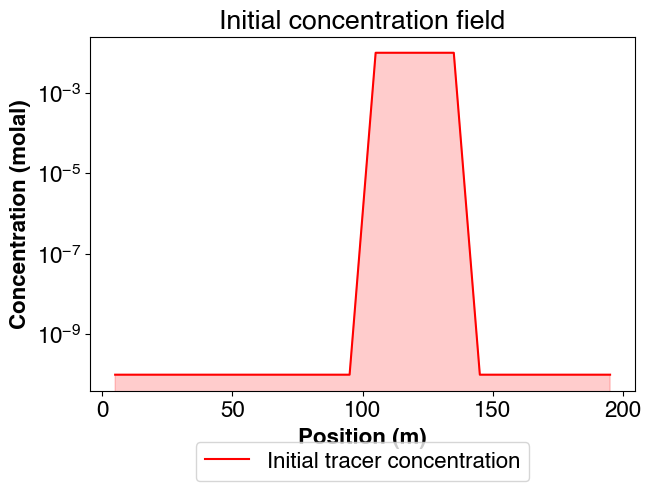

In [10]:
zone_high_conc_start = 10
zone_high_conc_stop = 14

c_min = 1e-10  # [mol/kg]
c_max = 1e-2  # [mol/kg]
c_init = np.ones((nx)) * c_min
c_init[zone_high_conc_start:zone_high_conc_stop] = c_max

plotter = ngp.NestedGridPlotter()
plotter.ax_dict["ax1-1"].plot(
    x_positions_in_meters,
    c_init,
    label="Initial tracer concentration",
    color="red",
)
plotter.ax_dict["ax1-1"].fill_between(
    x_positions_in_meters,
    0.0,
    c_init,
    alpha=0.2,
    color="red",
)
plotter.ax_dict["ax1-1"].set_xlabel("Position (m)", weight="bold")
plotter.ax_dict["ax1-1"].set_ylabel("Concentration (molal)", weight="bold")
plotter.ax_dict["ax1-1"].set_yscale("log")
plotter.ax_dict["ax1-1"].legend(loc="center", bbox_to_anchor=(0.5, -0.2), ncol=2)
plotter.ax_dict["ax1-1"].set_title("Initial concentration field")
plotter.fig.set_facecolor("w")

fname = "initial_tracer_concentration"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Forward problem in demonstrator

In [11]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dx)
fl_params = dmfwd.FlowParameters()
tr_params = dmfwd.TransportParameters(
    diffusion=D0, porosity=w0, crank_nicolson_diffusion=crank_nicolson_diffusion
)
gch_params = dmfwd.GeochemicalParameters(conc=c0, grade=0.0)


# We define a function to easily generate a model.
def create_base_model() -> dmfwd.ForwardModel:
    return dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Create two models

In [12]:
porosity_reference.shape

(20,)

In [20]:
model_reference = create_base_model()
model_estimate = create_base_model()
# Exact diffusion
model_reference.tr_model.porosity[:, 0] = porosity_reference.ravel("F")
# Estimated diffusion
model_estimate.tr_model.porosity[:, 0] = porosity_estimated.ravel("F")

model_reference.tr_model.set_initial_conc(c_init.reshape(nx, ny, order="F"))
model_estimate.tr_model.set_initial_conc(c_init.reshape(nx, ny, order="F"))

- Run the models

In [21]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

- Some fun plots, not very informative though...

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

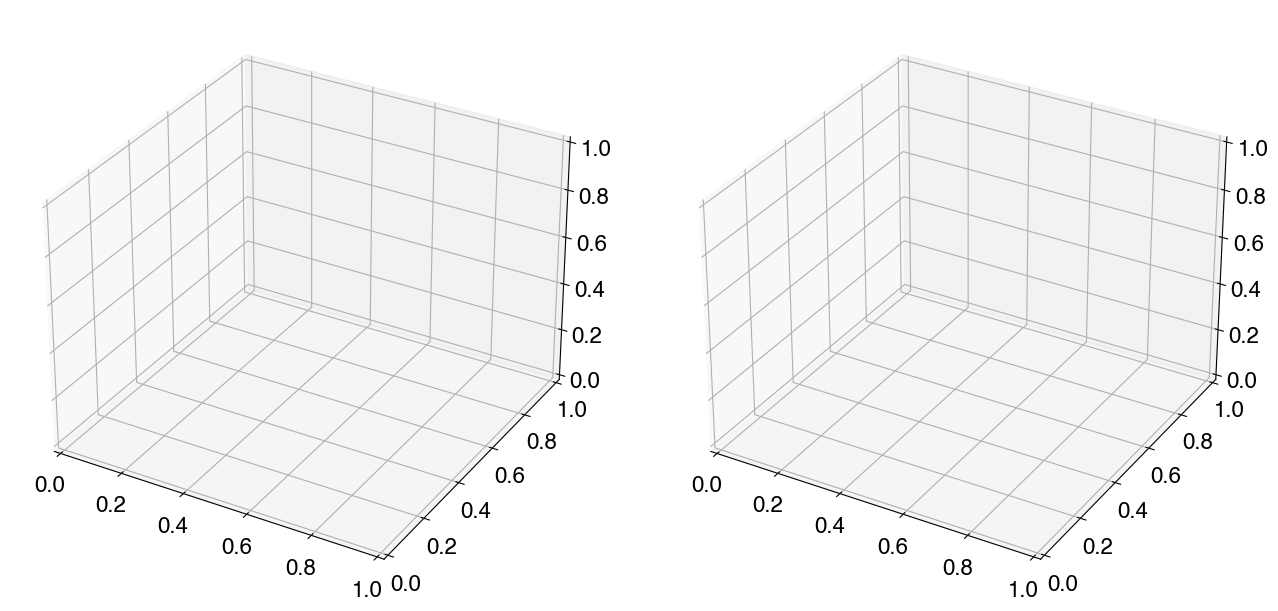

In [28]:
# Let's create a 3D plotter to visualize the results
plotter_3d = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (13, 6)},
    subfigs_params={"ncols": 2},
    subplots_mosaic_params={
        "reference demonstrator": {
            "mosaic": [["ax1-1"]],
            "subplot_kw": {"projection": "3d"},
        },
        "estimate demonstrator": {
            "mosaic": [["ax1-2"]],
            "subplot_kw": {"projection": "3d"},
        },
    },
)
plotter_3d.fig.patch.set_facecolor("w")

data: NDArrayFloat = model_reference.tr_model.conc[0, :, 0, :]
X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
ax = plotter_3d.ax_dict["ax1-1"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["reference demonstrator"].suptitle("True demonstrator")
ax.set_xlabel("Nodes #")
ax.set_ylabel("Timestep #")
ax.set_zlabel("Tracer concentration [molal]")

data: NDArrayFloat = model_estimate.tr_model.conc[0, :, 0, :]
ax = plotter_3d.ax_dict["ax1-2"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm, alpha=0.9)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["estimate demonstrator"].suptitle("Estimate demonstrator")

- Top view

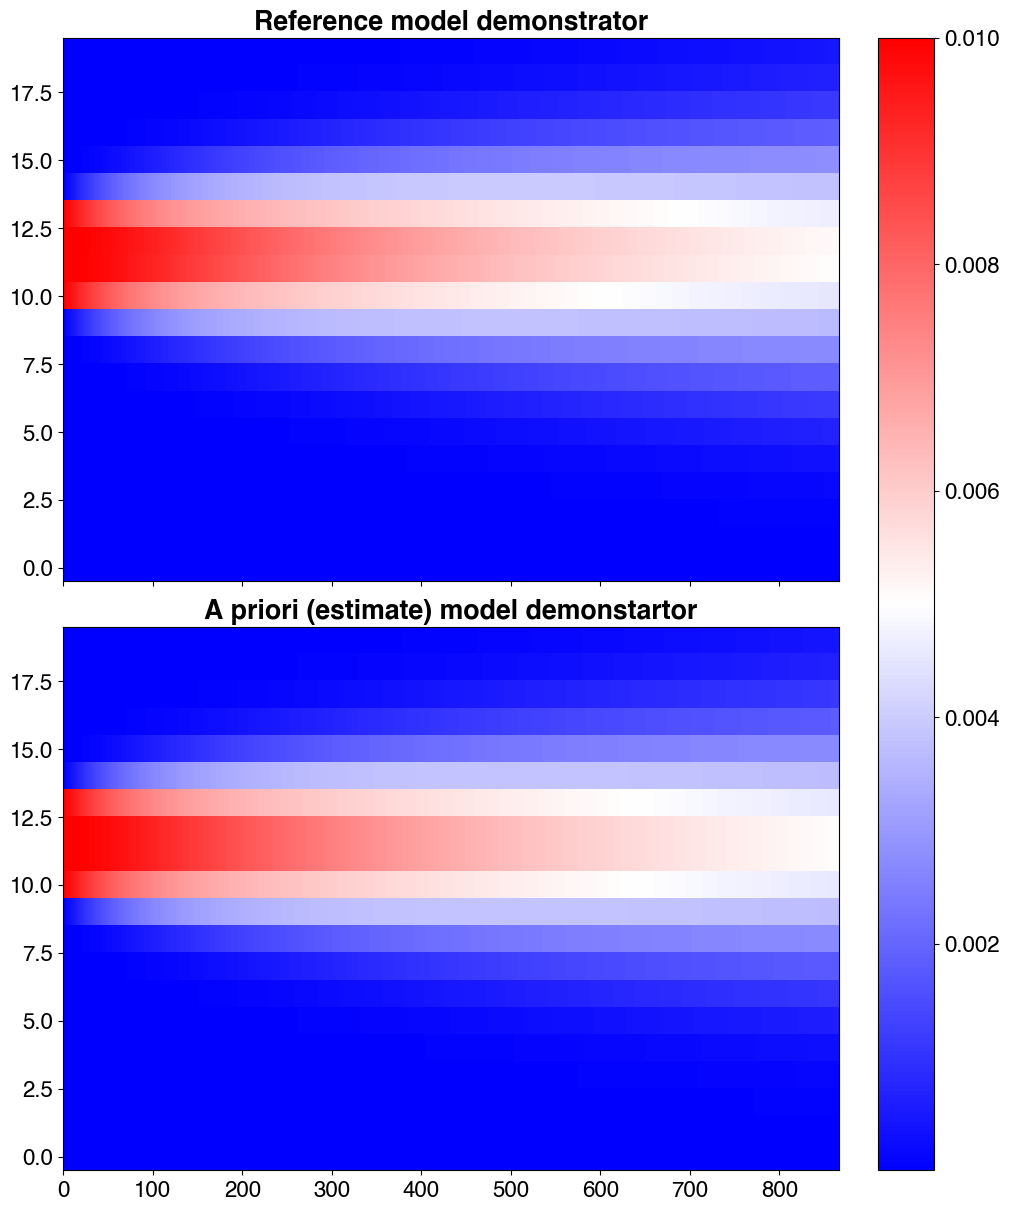

In [29]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference model demonstrator": model_reference.tr_model.conc[:, 0, :].T,
        "A priori (estimate) model demonstartor": model_estimate.tr_model.conc[
            :, 0, :
        ].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Let's now consider that we have some observation wells. We can plot what the observation well would sample in both cases and see the difference. Let's place three wells at positions `65m`, `105m` and `155m` (at the center of the nodes).

In [24]:
from typing import List, Tuple


def polygon_under_graph(x: np.ndarray, y: np.ndarray) -> List[Tuple[float, float]]:
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.0), *zip(x, y), (x[-1], 0.0)]


y_dim = model_reference.tr_model.conc.shape[2]
z_max = model_reference.tr_model.conc.max()
y = np.arange(y_dim)
z = np.ones(y_dim) * z_max

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(y, z)] * len(observation_locations)

poly1 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly2 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly3 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly4 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)

plotter_3d.ax_dict["ax1-1"].add_collection3d(poly1, zs=observation_locations, zdir="x")
plotter_3d.ax_dict["ax1-2"].add_collection3d(poly2, zs=observation_locations, zdir="x")
plotter_3d.ax_dict["ax1-3"].add_collection3d(poly3, zs=observation_locations, zdir="x")
plotter_3d.ax_dict["ax1-4"].add_collection3d(poly4, zs=observation_locations, zdir="x")

for node_id in observation_locations:
    x = [node_id] * 2
    y = [model_reference.tr_model.conc.shape[2]] * 2
    z = (0.0, z_max)

    plotter_3d.ax_dict["ax1-1"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax1-2"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax1-3"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax1-4"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )

fname = "tracer_concentration_true_vs_estimate_3D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

KeyError: 'ax1-3'

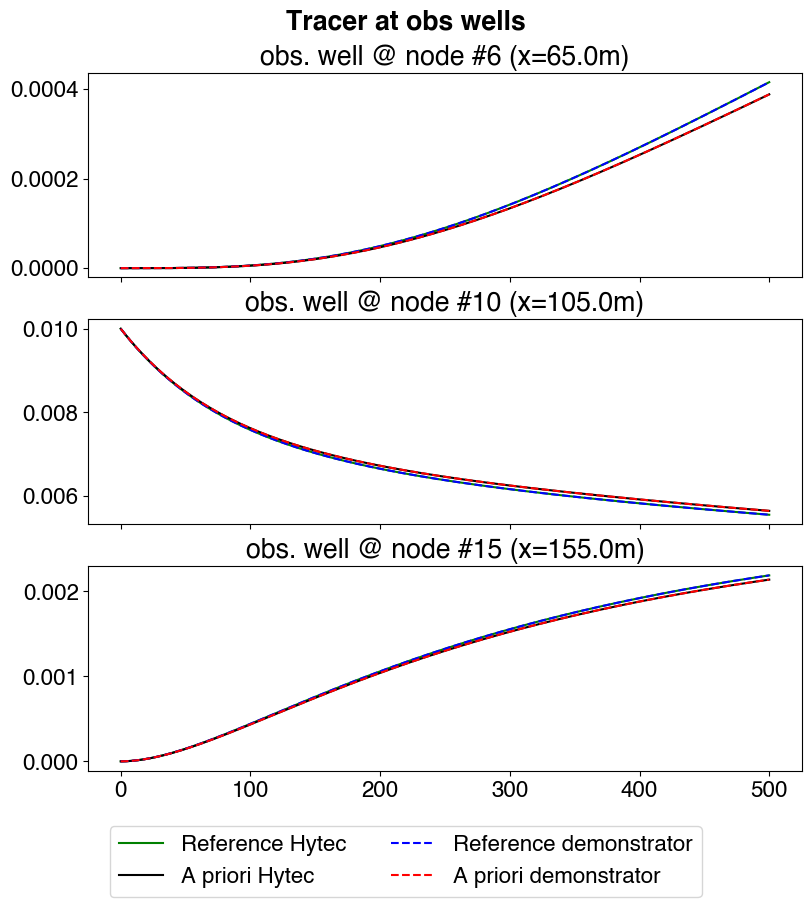

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(fwd_conc_true_hytec[node_id, 0, 0, :], label="Reference Hytec", c="g")
    ax.plot(fwd_conc_estimate_hytec[node_id, 0, 0, :], label="A priori Hytec", c="k")
    ax.plot(
        model_reference.tr_model.conc[node_id, 0, :],
        label="Reference demonstrator",
        c="b",
        linestyle="--",
        zorder=2,
    )
    ax.plot(
        model_estimate.tr_model.conc[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
        linestyle="--",
        zorder=2,
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Static plot
for ax_name in ["ax1-1", "ax1-2"]:
    plotter.get_axis(ax_name).plot(
        model_reference.tr_model.conc[:, 0, 0], c="red", label="Initial"
    )

# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Reference": {"y": fwd_conc_true_hytec[:, 0, 0, :], "kwargs": {"c": "blue"}},
        "Estimated": {
            "y": fwd_conc_estimate_hytec[:, 0, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="HYTEC conc",
    xlabel="Node #",
    ylabel="[mol/l]",
)

plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "Reference": {
            "y": model_reference.tr_model.conc[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.conc[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Demonstrator conc",
    xlabel="Node #",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(fwd_conc_estimate_hytec.shape[-1] / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {flux_sample_times[ts_btw_frames * frame] / 3600:.3f} h"


for ax_name in ["ax1-1", "ax1-2"]:
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        # handle = plotter.ax_dict["ax1-1"].axvline(
        #     x=well_pos, linestyle="--", line
        # )
        # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
        plotter.get_axis(ax_name).plot(
            well_pos,
            0.0002,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time()),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

- Create a function to add some noise to the observations

In [ ]:
noise_std: float = 2e-4  # This is an absolute value
rng = np.random.default_rng(2021)


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return rng.normal(mean_noise, noise_std, shape)


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(
    model_reference.fl_model.head[observation_locations, 0, :].shape
)

### Demonstrator


In [ ]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.POROSITY,
    lbounds=0.1,
    ubounds=0.9,
)


observables = []
for i, node_id in enumerate(observation_locations):
    vals = model_reference.tr_model.conc[node_id, 0, :] + obs_noise[i]
    timesteps = np.arange(vals.shape[0])

    observables.append(
        dminv.Observable(
            state_variable=dminv.StateVariable.CONCENTRATION,
            location=(slice(node_id, node_id + 1, 1), slice(None)),
            timesteps=timesteps,
            values=vals,
            uncertainties=noise_std,
        )
    )


# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=True,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(
    param.get_sliced_field(param.values, is_preconditioned=True), is_save_state=False
)

is_grad_ok = executor.is_adjoint_gradient_correct()

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 765.5712097811328
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0013062142191656964
INFO:root:Loss (scaled)         = 0.9999999999999999



In [ ]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


### HYTEC

In [ ]:
# 1) Copy the base simulation
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

# 2) Add the observation wells
for count, ix in enumerate(observation_locations):
    x = (ix + 0.5) * dx
    name = f"well_{ix}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {x},{dx/2}, {dx/2},{dy/2}",
            units="m",
        )
    )
    if fwd_conc_true_hytec[ix, 0, 0, 0] < 1e-5:
        zone.add_sub_item(hymd.Geochemistry(base_unit.name))
    else:
        zone.add_sub_item(hymd.Geochemistry(high_conc_unit.name))

    simu_inverse.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)
    vals = fwd_conc_true_hytec[ix, 0, 0, :] + obs_noise[count]

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable=species,
        units="mol/kg",
        timesteps=flux_sample_times,
        time_units="s",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.ones(vals.size) * ix,
    )
    simu_inverse.register_observable(
        zone.name, obs, obs_file_path=f"observables/{zone.name}_{species}_o.dat"
    )

# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb",
        hymd.AdjointStateStatus("enabled"),
        hymd.FdGradientCheck("initial"),
    ),
    hymd.AdjustedParameterConfig(
        "porosity",
        hymd.Lbound(0.1),
        hymd.Ubound(0.9),
    ),
)

simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(nt)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

INFO:root:The job is over ! Elapsed time = 0:00:52.895049


- Extract the adjoint variables computed for the first gradient

In [ ]:
print(f"columns = {simu_inverse.handlers.results.optim_res.adjoint_var_columns}")

columns = ['timestep', 'Zones', 'node-number []', 'adjoint-variable{T} []', 'x-distance']


In [ ]:
adj_conc_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{T} []", nx=nx
)
adj_conc_hytec.shape

(20, 1, 1, 501)

In [ ]:
adj_conc_hytec[:, 0, 0, ::-1]

array([[-1.98615769e-09, -1.27837753e-08, -5.03343026e-08, ...,
        -6.17683199e+04, -6.22930741e+04, -6.22930741e+04],
       [-4.98525580e-07, -2.71218817e-06, -9.43796613e-06, ...,
        -1.92248933e+05, -1.93481637e+05, -1.93481637e+05],
       [-1.25626460e-04, -5.58827240e-04, -1.70027009e-03, ...,
        -6.30001324e+05, -6.32846213e+05, -6.32846213e+05],
       ...,
       [-1.75639979e+01, -2.87790524e+01, -6.09122740e+01, ...,
        -6.00754702e+06, -6.02244486e+06, -6.02244486e+06],
       [-6.96995064e-02, -1.83352921e-01, -4.23623790e-01, ...,
        -2.44009754e+06, -2.44881483e+06, -2.44881483e+06],
       [-2.77687277e-04, -1.00707068e-03, -2.69080263e-03, ...,
        -1.04893103e+06, -1.05450825e+06, -1.05450825e+06]])

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Adj": {
            "x": (np.arange(nx) + 0.5) * dx,
            "y": adj_conc_hytec[:, 0, 0, ::-1],
            "kwargs": {"c": "blue"},
        },
    },
    nb_frames=nb_frames,
    title="Adjoint conentrations (HYTEC)",
    xlabel="X (m)",
    ylabel="[mol/l]",
)

plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "Adj": {
            "x": (np.arange(nx) + 0.5) * dx,
            "y": executor.adj_model.a_tr_model.a_conc[:, 0, ::-1],
            "kwargs": {"c": "blue"},
        },
    },
    nb_frames=nb_frames,
    title="Adjoint conentrations (PYRTID)",
    xlabel="X (m)",
    ylabel="[mol/l]",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(fwd_conc_estimate_hytec.shape[-1] / nb_frames)
    for frame in reversed(range(nb_frames)):
        yield f"time = {flux_sample_times[ts_btw_frames * frame] / 3600:.1f} h"


plotter.plot_animated_text(
    ax=plotter.ax_dict["ax1-1"],
    x=0.2,
    y=0.9,
    s=list(get_time()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=plotter.ax_dict["ax1-1"].transAxes,
    fontsize=14,
    fontweight="bold",
)

for ax_name in ["ax1-1", "ax1-2"]:
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        # handle = plotter.ax_dict["ax1-1"].axvline(
        #     x=well_pos, linestyle="--", line
        # )
        # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
        plotter.ax_dict[ax_name].plot(
            (well_pos + 1) * dx - dx / 2,
            0.000,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.add_axis_legend(ax_name)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("adjconc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Results comparison

The adjoint concentrations should be quite the same both in shape and intensity.

In [ ]:
adj_conc_hytec.shape

(20, 1, 1, 501)

In [ ]:
executor.adj_model.a_tr_model.a_conc.shape

(20, 1, 501)

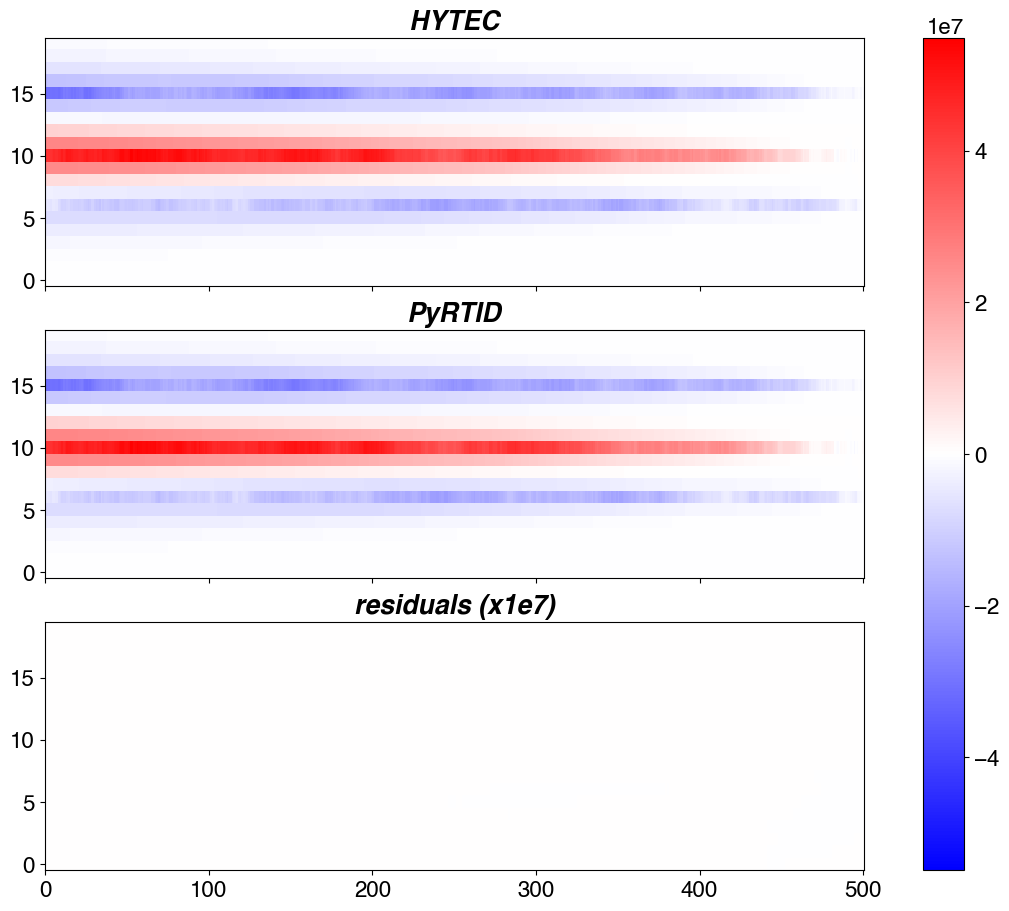

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 9)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "HYTEC": adj_conc_hytec[:, 0, 0, :].T,
        "PyRTID": executor.adj_model.a_tr_model.a_conc[:, 0, :].T,
        "residuals (x1e7)": (
            adj_conc_hytec[:, 0, 0, :] - executor.adj_model.a_tr_model.a_conc[:, 0, :]
        ).T
        * 1e7,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

Let's check the adjoint variables at the three observation wells. Note that only the right one has been used as an adjoint source (node_id == 15).

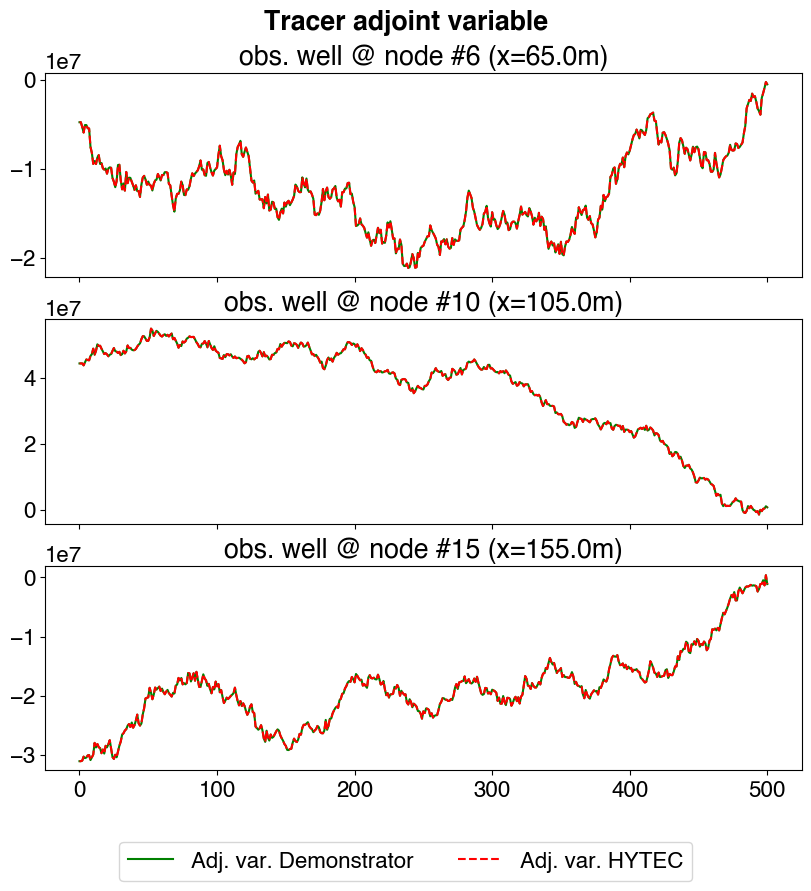

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        executor.adj_model.a_tr_model.a_conc[node_id, 0, :],
        label="Adj. var. Demonstrator",
        c="g",
    )
    ax.plot(
        adj_conc_hytec[node_id, 0, 0, :], label="Adj. var. HYTEC", c="r", linestyle="--"
    )

plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "adjoint_concentrations_dem_vs_hytec_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

In [ ]:
# Get the HYTEC  Adj gradient
hytec_fd_gradient = simu_inverse.handlers.results.optim_res.fd_gradients[0]
hytec_adjoint_gradient = simu_inverse.handlers.results.optim_res.adjoint_gradients[0]

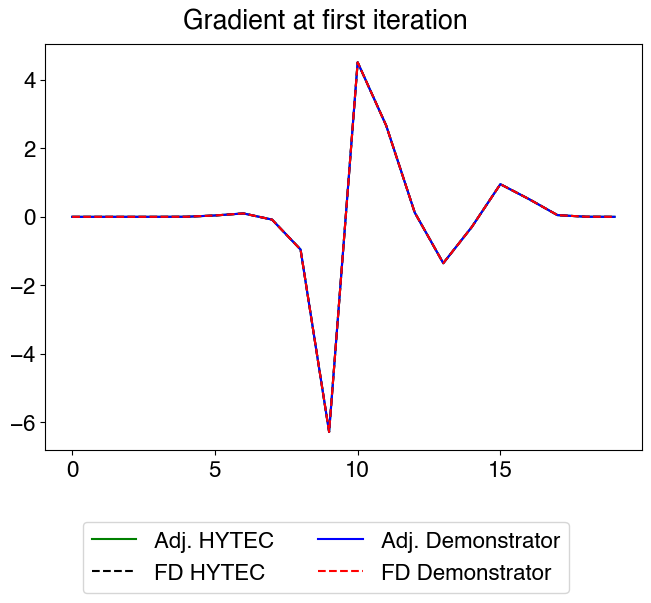

In [ ]:
# Here comes the python code
scaling_factor = executor.inv_model.scaling_factor

plotter = ngp.NestedGridPlotter()
ax = plotter.get_axis("ax1-1")

ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g", linestyle="-")
ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.plot(
    param.grad_adj_history[0] * scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)

plotter.fig.suptitle("Gradient at first iteration")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

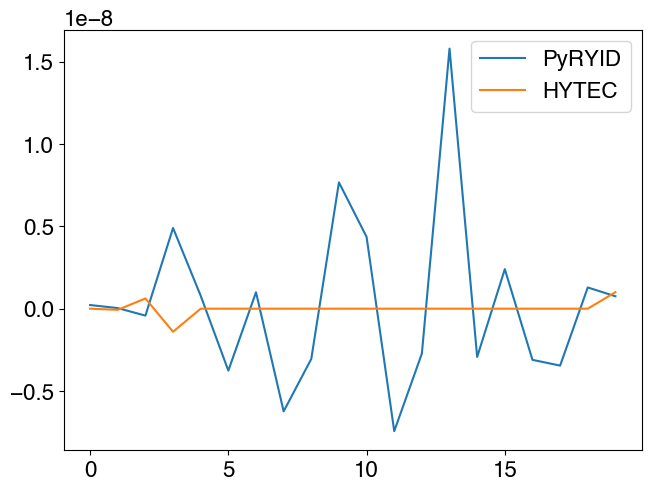

In [ ]:
plt.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0]) * scaling_factor,
    label="PyRYID",
)
plt.plot(hytec_adjoint_gradient["value"] - hytec_fd_gradient["value"], label="HYTEC")
plt.legend()

In [ ]:
raise ValueError

ValueError: 

In [ ]:
plt.plot(
    param.grad_adj_history[0].ravel() * scaling_factor
    - hytec_adjoint_gradient["value"].ravel(),
    label="Adjoint difference",
)
plt.plot(
    param.grad_fd_history[0].ravel() * scaling_factor
    - hytec_fd_gradient["value"].ravel(),
    label="FD difference",
)
plt.legend()